In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Convolution2D , MaxPooling2D , Dropout , Flatten, Lambda
import cv2
import pandas as pd
import random
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import ntpath
import csv

Using TensorFlow backend.


In [0]:
!git clone https://github.com/ahtchow/CarND-BehaviouralCloning
!ls CarND-BehaviouralCloning/

Cloning into 'CarND-BehaviouralCloning'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 94087 (delta 0), reused 3 (delta 0), pack-reused 94082
Receiving objects: 100% (94087/94087), 1.09 GiB | 15.49 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Checking out files: 100% (79515/79515), done.
driving_log2.csv  driving_log_diversify.csv  IMG   IMG_diversify
driving_log.csv   driving_log_udacity.csv    IMG2  IMG_udacity


In [0]:
column_labels = ['center' , 'left' , 'right' , 'steering' , 'throttle' , 'reverse' , 'speed']
data = pd.read_csv(os.path.join ('CarND-BehaviouralCloning', 'driving_log_diversify.csv'), names = column_labels)
pd.set_option('display.max_colwidth', -1) 

In [0]:
#Used to split image name from file directory
def path_split(path):
  head, tail = ntpath.split(path)
  return tail


In [0]:
data['center'] = data['center'].apply(path_split)
data['left'] = data['left'].apply(path_split)
data['right'] = data['right'].apply(path_split)

**Visualizing CSV File**

In [0]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


**Visualizing the Steering Data**


<BarContainer object of 25 artists>

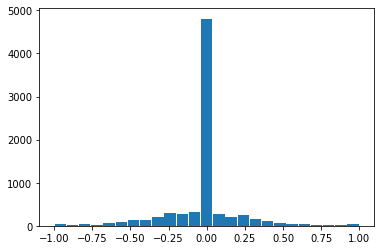

In [0]:
bins_on_hist = 25
steering_nums = []

hist , bins = np.histogram(data['steering'], bins_on_hist)
centered_bins = (bins[:-1]+ bins[1:])* 0.5 #Center the bins at 0 for histogram
plt.bar(centered_bins, hist, width = 0.075)

As you can see, there is an overwhelming number of data leading to straight driving. In order to remove bias, the straight data should be weighted less

In [0]:
straight_threshold = 630
excess_straight = []

'''
Iterate throaugh data
- If data is straight append to list
- Shuffle the list to randomize removal
- Remove until straight_threshold is achieved 
'''

for j in range(bins_on_hist):
  remove_list = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: 
      remove_list.append(i)
  
  remove_list = shuffle(remove_list)
  remove_list = remove_list[straight_threshold:]
  excess_straight.extend(remove_list)
  #excess_striaght is the final list of steering data to be removed
  
print('Total Data' , len(data['steering']))
print('Removed' , len(excess_straight))

data.drop(data.index[excess_straight] , inplace = True)
print( 'Remaining' , len(data) )


Total Data 7617
Removed 4177
Remaining 3440


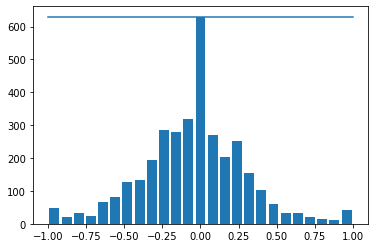

In [0]:
hist,_ = np.histogram(data['steering'], bins_on_hist)
plt.bar(centered_bins, hist , width = 0.065)
plt.plot((-1,1),(straight_threshold,straight_threshold))

In [0]:
def readData(path):

  steering_angles, images = [],[]
  adjustment_factor = 0.0

  for i in range(len(data)):
    data_entry = data.iloc[i]
    perspective_images = [data_entry[0], data_entry[1], data_entry[2]]
    perspective_images = map(readImageDirectory, perspective_images)
    images += perspective_images
    steering_angles.append(float(data_entry[3]))
    should_adjust = False
    if float(data_entry[3]) != 0:
      should_adjust = True
    steering_angles.append(float(data_entry[3])- adjustment_factor*should_adjust)
    steering_angles.append(float(data_entry[3])+ adjustment_factor*should_adjust)
  return np.array(images), np.array(steering_angles)

def readImageDirectory(img_directory):
  img_directory = img_directory.split('\\')[-1]
  img_directory = 'CarND-BehaviouralCloning/IMG_diversify/' + img_directory
  return img_directory


In [0]:
driving_log_directory = 'CarND-BehaviouralCloning/driving_log_diversify.csv'
images, steering_angles = readData(driving_log_directory)

**Sample Images**

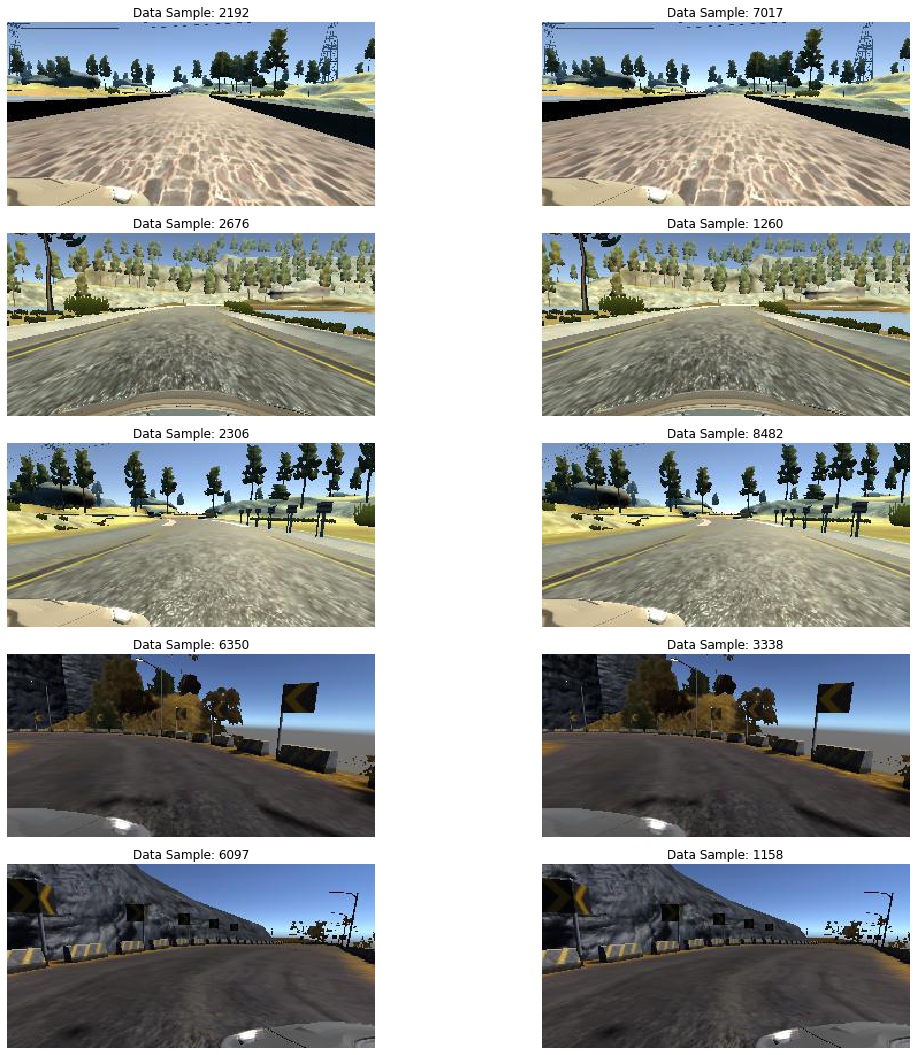

In [0]:
from random import randint
fig, axis = plt.subplots( nrows= 5, ncols= 2 , figsize = (15,15))
for i in range(5):
  random_index = randint(0, images.shape[0]-1)
  random_index2 = randint(0, images.shape[0] -1)
  img = mpimg.imread(images[random_index])
  img2 = mpimg.imread(images[random_index2])
  fig.tight_layout()
  axis[i][0].imshow(img)
  axis[i][1].imshow(img)
  axis[i][0].set_title('Data Sample: ' + str(random_index))
  axis[i][1].set_title('Data Sample: ' + str(random_index2))
  axis[i][0].axis('off')
  axis[i][1].axis('off')


**Training/Validation Data Split**

Training Set: 8256
Validation Set: 2064


Text(0.5, 1.0, 'Validation set')

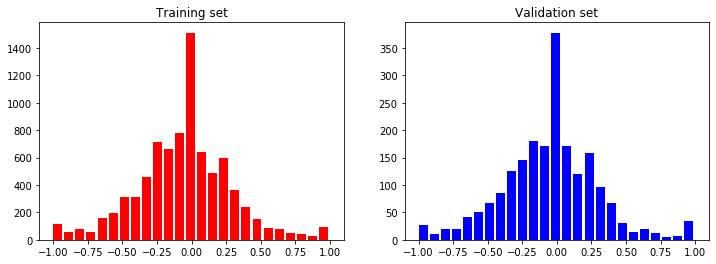

In [0]:
img_train, img_valid, ang_train, ang_valid = train_test_split(images, steering_angles, test_size = 0.2 , random_state = 6)
print('Training Set: ' + str(len(img_train)))
print('Validation Set: ' + str(len(img_valid)))

fig, axis = plt.subplots(nrows =1 , ncols = 2 , figsize= (12,4))
axis[0].hist( ang_train , bins = bins_on_hist , width = 0.065 , color = 'red')
axis[0].set_title('Training set')
axis[1].hist( ang_valid , bins = bins_on_hist , width = 0.065 , color = 'blue')
axis[1].set_title('Validation set')

Note: Still very much straight driving data

**Data Augmentation**

Note:
  
Will not be performing any augmentations which require the image to rotate or Shear. It will Only cause more noise and confusion for network. 

Goal: Diversify and generalize dataset.

Four Augmentations: 
1. Scale size of image (Intensify Feautures)
2. Alter brightness
3. Flip Images on  Y axis
4. Translate by a small amount

Source: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_geometric.html#imgaug.augmenters.geometric.Affine

In [0]:
#Zoom to see closer look at feautures
def scaleImage(img):
  zoom = iaa.Affine(scale = (1,1.2))
  img = zoom.augment_image(img)
  return img

#Multiplier Range from 0.5 brightness factor to 1.2
def alterBrightness(img): 
  brightness_filter = iaa.Multiply((0.5 , 1.2)) 
  img = brightness_filter.augment_image(img)
  return img

#Flip Image to remove bias of driving left or right
def flipOnY(img,angle):
  img = cv2.flip(img,1)
  flippled_angle = -angle
  return img,flippled_angle

#Translate image bby 0-5% in x/y axis
def translateImg(img):
  translate = iaa.Affine( translate_percent = {'x': (-0.05 , 0.05) , 'y': (-0.05, 0.05)})
  img = translate.augment_image(img)
  return img

# Apply randomly at 50%
def applyAugmentationRandomly(img, angle):
  if random.randint(0,1) == 1: 
    img = scaleImage(img)
  if random.randint(0,1) == 1:
    img = alterBrightness(img)
  if random.randint(0,1) == 1:
    img , angle = flipOnY(img , angle)
  if random.randint(0,1) == 1:
    img = translateImg(img)
  return img , angle

**Sample Augmented Images**

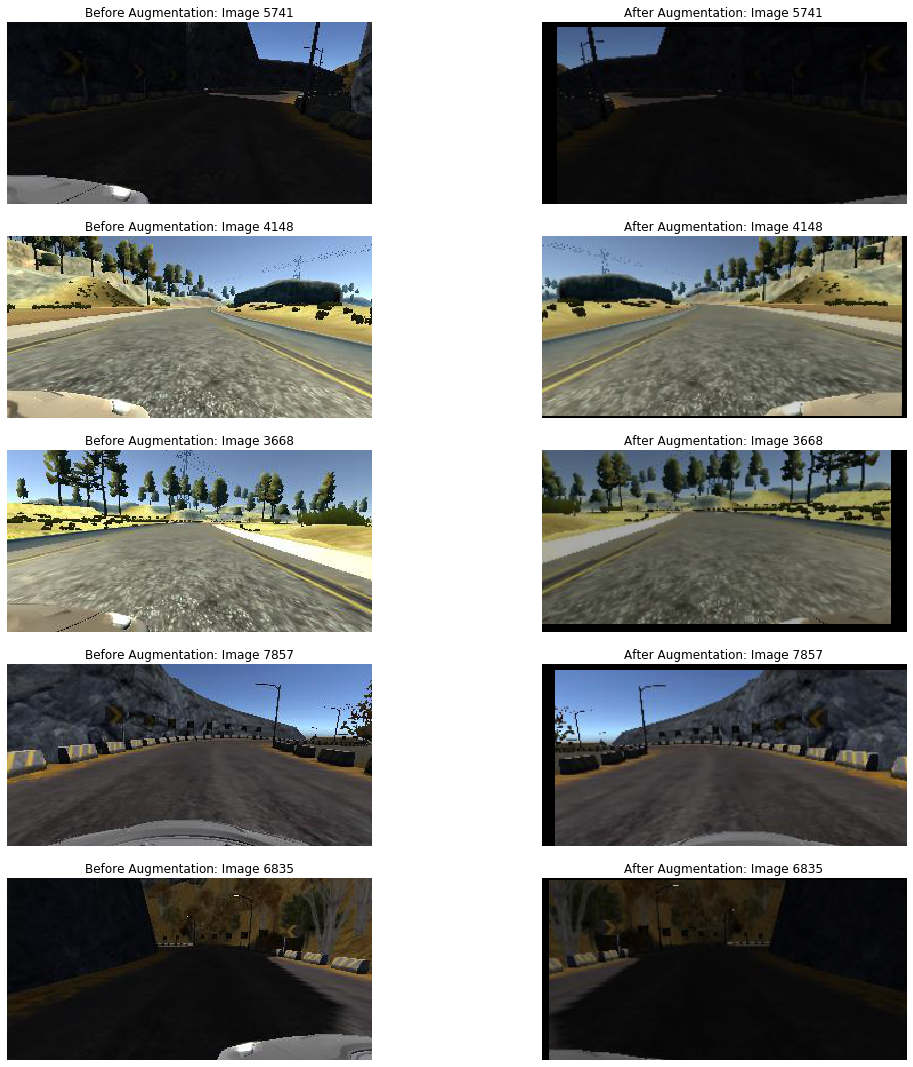

In [0]:
random_index = random.randint(0,images.shape[0]-1)
sample_img = images[random_index]
sample_angle = steering_angles[random_index]

fig, axis = plt.subplots(nrows= 5, ncols=2, figsize = (15,15))
plt.tight_layout()

for i in range(5):
  random_index = random.randint(0,images.shape[0] -1)
  sample_img = images[random_index]
  sample_img = mpimg.imread(images[random_index])
  sample_angle = steering_angles[random_index]
  axis[i][0].imshow(sample_img)
  axis[i][0].axis('off')
  axis[i][0].set_title('Before Augmentation: Image ' +str(random_index))

  #Apply Transformation 
  sample_img = scaleImage(sample_img)
  sample_img = alterBrightness(sample_img)
  sample_img , sample_angle = flipOnY(sample_img , sample_angle)
  sample_img = translateImg(sample_img)

  axis[i][1].imshow(sample_img)
  axis[i][1].axis('off')
  axis[i][1].set_title('After Augmentation: Image ' +str(random_index))

**Image Preprocessing**

In [0]:
#Crop top and bottom to remove hood and trees
def cropImage(img):
  img = img[65:135,:,:]
  return img

#Convert Color Space to YUV
def convertColorChannel(img):
  img = cv2.cvtColor(img , cv2.COLOR_RGB2YUV)
  return img

#Apply Gaussian Blur
def applyGaussianBlur(img):
  img = cv2.GaussianBlur(img, (3,3), 0)
  return img

#Apply Preprocessing Functions
def imgPreprocessing(img):
  img = cropImage(img)
  img = convertColorChannel(img)
  img = applyGaussianBlur(img)
  img = cv2.resize(img,(200, 66))
  img = img/255
  return img
  

**Data Generator**

Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.

A generator runs on the fly. A process that can run separately from another main routine, which makes it a useful Python function. Instead of using return, the generator uses yield, which still returns the desired output values but saves the current values of all the generator's variables. 

In [0]:
def imageGenerator(images, steering_angles, batch_size, is_train_data):
  #Always running as long as program is running
  while True:
    compiled_images, compiled_angles = [], []

    for i in range(batch_size):
      random_index = random.randint(0, images.shape[0] - 1)
      image = mpimg.imread(images[random_index])
      steering_angle = steering_angles[random_index]
      #Validation Data should not be augmented,in order to still represent original data
      if is_train_data:
        image, steering_angle = applyAugmentationRandomly(image , steering_angle)
      image = imgPreprocessing(image)
      compiled_images.append(image)
      compiled_angles.append(steering_angle)
    
    yield (np.asarray(compiled_images), np.asarray(compiled_angles))

In [0]:
# Continue to run generator at batch size of 5 images per call
img_train_compiled , ang_train_compiled = next(imageGenerator(img_train , ang_train , 5 ,True))
img_valid_compiled , ang_valid_compiled = next(imageGenerator(img_valid , ang_valid , 5 , False))

**Final Image Before Processing**

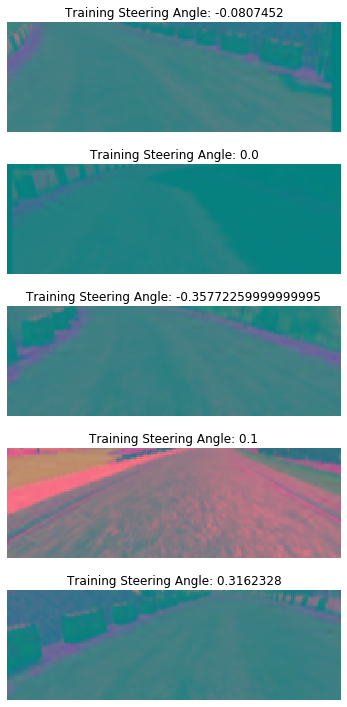

In [0]:
fig, axis = plt.subplots( nrows = 5, ncols = 1 , figsize = (15,10))
plt.tight_layout()

for i in range(5):
  axis[i].imshow(img_train_compiled[i])
  axis[i].axis('off')
  axis[i].set_title('Training Steering Angle: ' + str(ang_train_compiled[i]))

**NVIDIA CNN Architecture**

![alt text](https://github.com/navoshta/behavioral-cloning/raw/master/images/model.png)

In [0]:
print(img_train_compiled.shape)

(5, 66, 200, 3)


In [0]:
def nvidiaBehaviourCloningCNN():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2,2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2,2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))
  
  model.compile(loss='mse', optimizer = 'adam')
  return model


In [0]:
model = nvidiaBehaviourCloningCNN()
print(model.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [0]:
fit = model.fit_generator(imageGenerator(img_train , ang_train , 100 , 1) ,
                                          steps_per_epoch = 150, 
                                          epochs = 21 , 
                                          validation_data = imageGenerator(img_valid, ang_valid ,100, 0), 
                                          validation_steps = 100 , 
                                          verbose =1 , 
                                          shuffle = 1)




Epoch 1/21





150/150 [==============================] - 101s 672ms/step - loss: 0.1786 - val_loss: 0.1210
Epoch 2/21
150/150 [==============================] - 87s 582ms/step - loss: 0.1137 - val_loss: 0.1212
Epoch 3/21
150/150 [==============================] - 86s 570ms/step - loss: 0.1476 - val_loss: 0.1277
Epoch 4/21
150/150 [==============================] - 86s 570ms/step - loss: 0.1197 - val_loss: 0.1186
Epoch 5/21
150/150 [==============================] - 86s 573ms/step - loss: 0.1159 - val_loss: 0.1200
Epoch 6/21
150/150 [==============================] - 86s 575ms/step - loss: 0.1119 - val_loss: 0.1161
Epoch 7/21
150/150 [==============================] - 86s 575ms/step - loss: 0.0988 - val_loss: 0.0912
Epoch 8/21
150/150 [==============================] - 86s 575ms/step - loss: 0.0930 - val_loss: 0.0708
Epoch 9/21
150/150 [==============================] - 87s 583ms/step - loss: 0.0905 - val_loss: 0.0728
Epoch 10/21
150/150 [==============================] - 87s 577ms

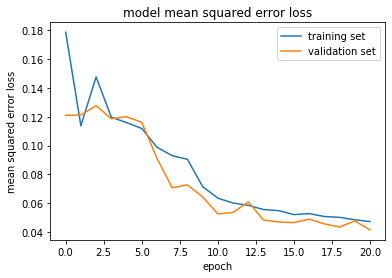

In [0]:
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [0]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')